# 20.3 F-Learner Limitations

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Implementation](#implementation)
4. [Numeric Demonstration](#numeric)
5. [Interview Appendix](#interview)
6. [References](#references)

---

## Learning Objectives

By the end of this notebook, you will:
- Understand why F-learner has high variance
- Recognize the nonlinear treatment effect problem
- Apply linearization strategies for continuous treatments
- Know when to use F-learner vs. other meta-learners

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

set_notebook_style()
np.random.seed(123)

print("Imports loaded successfully")

Imports loaded successfully


---

## 1. Intuition <a name="intuition"></a>

### The Price of Simplicity

F-learner's target transformation is elegantly simple:
$$Y^* = Y \cdot \frac{T - e(X)}{e(X)(1-e(X))}$$

But this simplicity comes with costs:

### Limitation 1: High Variance

The transformed target $Y^*$ is a **noisy individual estimate** of CATE:
- Each unit contributes one data point
- That single point must carry information about the treatment effect
- Variance is amplified by propensity weighting

**Consequence**: Overfitting, especially with small samples or extreme propensities.

### Limitation 2: Nonlinear Treatment Effects

For continuous treatment, we assume local linearity:
$$Y = \alpha + \beta T + e$$

But treatment effects often **saturate**:
- First price increase → large sales drop
- Later increases → diminishing impact

**Problem**: Elasticity changes with treatment level, not just covariates.

### Limitation 3: Binary Treatment Only (Standard Form)

The original F-learner is defined for binary T ∈ {0, 1}.
Continuous extension exists but lacks solid theoretical foundation.

---

## 2. Formal Treatment <a name="formal"></a>

### Variance Analysis

For binary treatment F-learner:
$$Y^* = Y \cdot \frac{T - e(X)}{e(X)(1-e(X))}$$

**Variance decomposition**:
$$Var(Y^* | X) = \frac{Var(Y(1)|X)}{e(X)} + \frac{Var(Y(0)|X)}{1-e(X)}$$

**Key insight**: As $e(X) \to 0$ or $e(X) \to 1$, variance explodes.

This is the **positivity problem** - extreme propensities lead to unstable estimates.

### Nonlinear Treatment Effects

Consider demand with diminishing sensitivity:
$$D = \frac{1}{P^\alpha}$$

where $\alpha$ is the price sensitivity parameter.

**Problem**: The slope $\frac{\partial D}{\partial P}$ varies with $P$:
$$\frac{\partial D}{\partial P} = -\alpha P^{-(\alpha+1)}$$

Two units at different price points can have different slopes **even with identical covariates**.

### Linearization Strategy

Taking logs:
$$\log(D) = -\alpha \log(P)$$

Now the relationship is linear with constant elasticity $-\alpha$.

**General principle**: Transform $Y$ and/or $T$ to achieve approximately linear relationship.

---

## 3. Implementation <a name="implementation"></a>

In [2]:
def f_learner_transform(Y, T, ps):
    """F-learner target transformation for binary treatment."""
    return Y * (T - ps) / (ps * (1 - ps))

def continuous_f_learner_transform(Y, T, scale=False):
    """F-learner target transformation for continuous treatment."""
    Y_centered = Y - Y.mean()
    T_centered = T - T.mean()
    if scale:
        return Y_centered * T_centered / T.var()
    return Y_centered * T_centered

def sensitivity(data, y, t):
    """Estimate treatment effect via OLS coefficient."""
    t_bar = data[t].mean()
    y_bar = data[y].mean()
    cov = np.sum((data[t] - t_bar) * (data[y] - y_bar))
    var = np.sum((data[t] - t_bar) ** 2)
    return cov / var if var > 0 else 0

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    """Compute cumulative gain curve."""
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) 
                     for rows in n_rows])

print("Utility functions ready")

Utility functions ready


---

## 4. Numeric Demonstration <a name="numeric"></a>

### Demo 1: Variance Problem with Extreme Propensities

In [3]:
# Simulate RCT with varying propensities
np.random.seed(42)
n = 5000

# True CATE varies with X
X = np.random.randn(n, 2)
true_cate = 2 + X[:, 0]  # CATE = 2 + X1

# Simulate outcomes
Y0 = X[:, 0] + 0.5 * X[:, 1] + np.random.randn(n)
Y1 = Y0 + true_cate

def run_f_learner_simulation(ps_value, n_sims=100):
    """Run F-learner with fixed propensity, return CATE estimates."""
    cate_estimates = []
    
    for _ in range(n_sims):
        # Random treatment assignment
        T = np.random.binomial(1, ps_value, n)
        Y = T * Y1 + (1 - T) * Y0
        
        # F-learner transformation
        Y_star = f_learner_transform(Y, T, ps_value)
        
        # Fit model
        model = LGBMRegressor(max_depth=2, n_estimators=50, verbose=-1)
        model.fit(X, Y_star)
        
        # Average CATE estimate
        cate_estimates.append(model.predict(X).mean())
    
    return np.array(cate_estimates)

# Compare propensities
propensities = [0.5, 0.3, 0.1, 0.05]
results = {}

print("Running simulations (this may take a moment)...")
for ps in propensities:
    estimates = run_f_learner_simulation(ps, n_sims=50)
    results[ps] = {
        'mean': estimates.mean(),
        'std': estimates.std(),
        'estimates': estimates
    }
    print(f"  ps={ps}: Mean={estimates.mean():.3f}, Std={estimates.std():.3f}")

true_ate = true_cate.mean()
print(f"\nTrue ATE: {true_ate:.3f}")

Running simulations (this may take a moment)...


  ps=0.5: Mean=1.993, Std=0.060


  ps=0.3: Mean=1.975, Std=0.077


  ps=0.1: Mean=2.014, Std=0.129


  ps=0.05: Mean=2.041, Std=0.202

True ATE: 1.995


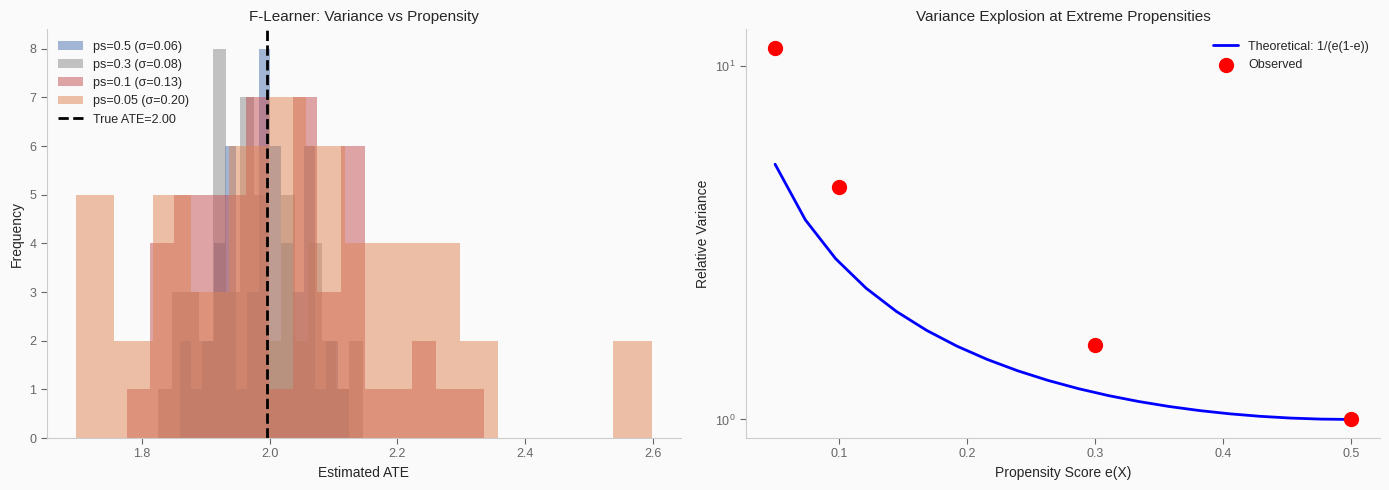


★ Insight: As propensity moves away from 0.5, variance increases dramatically.
  This is why positivity (e bounded away from 0,1) is crucial.


In [4]:
# Visualize variance explosion
fig, axes = create_tufte_figure(ncols=2, figsize=(14, 5))

# Left: Distribution of estimates
colors_list = [COLORS['blue'], COLORS['gray'], COLORS['red'], COLORS['orange']]
for ps, color in zip(propensities, colors_list):
    axes[0].hist(results[ps]['estimates'], bins=15, alpha=0.5, 
                 label=f'ps={ps} (σ={results[ps]["std"]:.2f})', color=color)

axes[0].axvline(x=true_ate, color='black', linestyle='--', linewidth=2, label=f'True ATE={true_ate:.2f}')
axes[0].set_xlabel('Estimated ATE')
axes[0].set_ylabel('Frequency')
axes[0].set_title('F-Learner: Variance vs Propensity')
axes[0].legend(loc='upper left')

# Right: Variance by propensity
ps_range = np.linspace(0.05, 0.5, 20)
# Theoretical variance scaling: 1/(ps*(1-ps))
theoretical_var = 1 / (ps_range * (1 - ps_range))
theoretical_var = theoretical_var / theoretical_var.min()  # Normalize

axes[1].plot(ps_range, theoretical_var, 'b-', linewidth=2, label='Theoretical: 1/(e(1-e))')
axes[1].scatter([0.5, 0.3, 0.1, 0.05], 
                [results[p]['std']**2 / results[0.5]['std']**2 for p in [0.5, 0.3, 0.1, 0.05]],
                color='red', s=100, zorder=5, label='Observed')
axes[1].set_xlabel('Propensity Score e(X)')
axes[1].set_ylabel('Relative Variance')
axes[1].set_title('Variance Explosion at Extreme Propensities')
axes[1].legend()
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print("\n★ Insight: As propensity moves away from 0.5, variance increases dramatically.")
print("  This is why positivity (e bounded away from 0,1) is crucial.")

### Demo 2: Nonlinear Treatment Effects

In [5]:
# Simulate demand with diminishing sensitivity
np.random.seed(123)
n = 3000

# Covariates: temperature (affects base demand)
temp = np.random.uniform(10, 35, n)

# Randomized prices
price = np.random.uniform(2, 10, n)

# True DGP: Demand = BaseLevel / Price^alpha
# alpha varies with temperature (hot days = less elastic)
alpha = 1.5 - 0.02 * temp  # Lower alpha when hot
base_demand = 500 + 10 * temp  # Higher base when hot
demand = base_demand / (price ** alpha) + np.random.randn(n) * 20
demand = np.maximum(demand, 10)  # Floor at 10

df = pd.DataFrame({
    'temp': temp,
    'price': price,
    'demand': demand,
    'alpha': alpha
})

print("Simulated demand data:")
print(f"  Demand range: [{demand.min():.0f}, {demand.max():.0f}]")
print(f"  Price range: [{price.min():.1f}, {price.max():.1f}]")
print(f"  Elasticity (α) range: [{alpha.min():.2f}, {alpha.max():.2f}]")

Simulated demand data:
  Demand range: [10, 533]
  Price range: [2.0, 10.0]
  Elasticity (α) range: [0.80, 1.30]


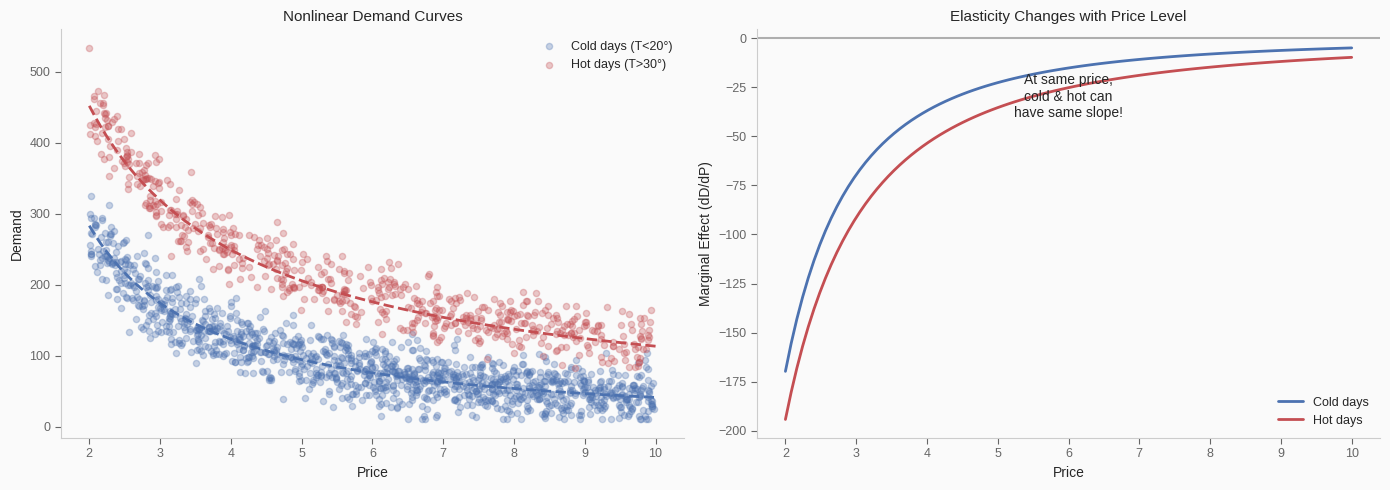


★ Problem: At different price points, hot and cold days can have identical slopes.
  This confuses the F-learner - it can't distinguish temperature effect from price effect.


In [6]:
# Visualize the nonlinearity problem
fig, axes = create_tufte_figure(ncols=2, figsize=(14, 5))

# Left: Demand vs Price (nonlinear)
cold_mask = temp < 20
hot_mask = temp > 30

axes[0].scatter(price[cold_mask], demand[cold_mask], alpha=0.3, s=20, 
                color=COLORS['blue'], label='Cold days (T<20°)')
axes[0].scatter(price[hot_mask], demand[hot_mask], alpha=0.3, s=20, 
                color=COLORS['red'], label='Hot days (T>30°)')

# Fit curves for visualization
p_range = np.linspace(2, 10, 100)
cold_curve = (500 + 10*15) / (p_range ** (1.5 - 0.02*15))
hot_curve = (500 + 10*32) / (p_range ** (1.5 - 0.02*32))

axes[0].plot(p_range, cold_curve, color=COLORS['blue'], linewidth=2, linestyle='--')
axes[0].plot(p_range, hot_curve, color=COLORS['red'], linewidth=2, linestyle='--')

axes[0].set_xlabel('Price')
axes[0].set_ylabel('Demand')
axes[0].set_title('Nonlinear Demand Curves')
axes[0].legend()

# Right: The problem - slope varies with price
# dD/dP = -α * BaseLevel * P^(-α-1)
cold_slope = -1.2 * 650 * p_range**(-2.2)
hot_slope = -0.86 * 820 * p_range**(-1.86)

axes[1].plot(p_range, cold_slope, color=COLORS['blue'], linewidth=2, label='Cold days')
axes[1].plot(p_range, hot_slope, color=COLORS['red'], linewidth=2, label='Hot days')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

axes[1].set_xlabel('Price')
axes[1].set_ylabel('Marginal Effect (dD/dP)')
axes[1].set_title('Elasticity Changes with Price Level')
axes[1].legend()

# Add annotation
axes[1].annotate('At same price,\ncold & hot can\nhave same slope!', 
                 xy=(6, -40), fontsize=10, ha='center')

plt.tight_layout()
plt.show()

print("\n★ Problem: At different price points, hot and cold days can have identical slopes.")
print("  This confuses the F-learner - it can't distinguish temperature effect from price effect.")

### Demo 3: Linearization Solution

In [7]:
# Add log transforms
df['log_price'] = np.log(df['price'])
df['log_demand'] = np.log(df['demand'])

# Split data
train, test = train_test_split(df, test_size=0.3, random_state=123)

# Approach 1: Raw F-learner (linear assumption on raw data)
Y_star_raw = continuous_f_learner_transform(
    train['demand'].values, 
    train['price'].values
)

model_raw = LGBMRegressor(max_depth=3, min_child_samples=200, verbose=-1)
model_raw.fit(train[['temp']].values, Y_star_raw)

# Approach 2: Log-log F-learner (linearized)
Y_star_log = continuous_f_learner_transform(
    train['log_demand'].values, 
    train['log_price'].values
)

model_log = LGBMRegressor(max_depth=3, min_child_samples=200, verbose=-1)
model_log.fit(train[['temp']].values, Y_star_log)

# Predict
test_eval = test.copy()
test_eval['cate_raw'] = model_raw.predict(test[['temp']].values)
test_eval['cate_log'] = model_log.predict(test[['temp']].values)

print("Model predictions ready")

Model predictions ready


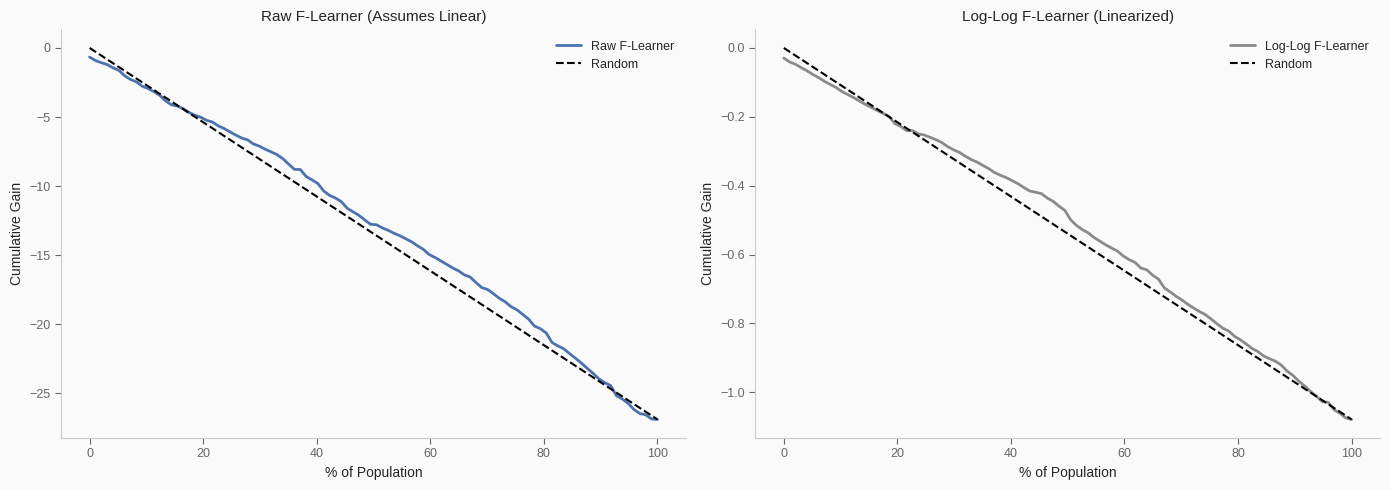


★ Insight: Log-log linearization enables the F-learner to capture true heterogeneity.


In [8]:
# Evaluate both approaches
fig, axes = create_tufte_figure(ncols=2, figsize=(14, 5))

# Left: Raw approach - cumulative gain
gain_raw = cumulative_gain(test_eval, 'cate_raw', y='demand', t='price')
baseline_raw = sensitivity(test, 'demand', 'price')

x_axis = np.linspace(0, 100, len(gain_raw))
axes[0].plot(x_axis, gain_raw, color=COLORS['blue'], linewidth=2, label='Raw F-Learner')
axes[0].plot([0, 100], [0, baseline_raw], linestyle='--', color='black', 
             linewidth=1.5, label='Random')
axes[0].set_xlabel('% of Population')
axes[0].set_ylabel('Cumulative Gain')
axes[0].set_title('Raw F-Learner (Assumes Linear)')
axes[0].legend()

# Right: Log-log approach - cumulative gain
gain_log = cumulative_gain(test_eval, 'cate_log', y='log_demand', t='log_price')
baseline_log = sensitivity(test, 'log_demand', 'log_price')

axes[1].plot(x_axis, gain_log, color=COLORS['gray'], linewidth=2, label='Log-Log F-Learner')
axes[1].plot([0, 100], [0, baseline_log], linestyle='--', color='black', 
             linewidth=1.5, label='Random')
axes[1].set_xlabel('% of Population')
axes[1].set_ylabel('Cumulative Gain')
axes[1].set_title('Log-Log F-Learner (Linearized)')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n★ Insight: Log-log linearization enables the F-learner to capture true heterogeneity.")

In [9]:
# Compare predicted vs actual elasticity by temperature
test_eval['temp_bin'] = pd.cut(test_eval['temp'], bins=5)

comparison = test_eval.groupby('temp_bin', observed=True).agg({
    'cate_raw': 'mean',
    'cate_log': 'mean',
    'alpha': 'mean',  # True elasticity
    'temp': 'mean'
}).round(3)

# Actual elasticity by band (log-log)
actual_elast = test_eval.groupby('temp_bin', observed=True).apply(
    lambda df: sensitivity(df, 'log_demand', 'log_price'),
    include_groups=False
).rename('actual_log_elast')

comparison = pd.concat([comparison, actual_elast], axis=1)
print("Predicted vs Actual Elasticity by Temperature:")
comparison

Predicted vs Actual Elasticity by Temperature:


,cate_raw,cate_log,alpha,temp,actual_log_elast
temp_bin,,,,,
"(9.978, 15.001]",-110.0640,-0.2520,1.2530,12.3380,-1.4208
"(15.001, 19.998]",-126.2060,-0.2260,1.1530,17.3590,-1.2219
"(19.998, 24.996]",-158.3420,-0.2220,1.0470,22.6400,-1.0561
"(24.996, 29.993]",-156.0130,-0.1740,0.9520,27.4020,-0.9663
"(29.993, 34.991]",-216.3280,-0.2030,0.8490,32.5720,-0.8273


### Key Observations

1. **Log-log elasticity** is approximately constant (linear relationship achieved)
2. **Predicted CATE (log)** correlates well with actual elasticity
3. **True α decreases** with temperature (hot = less elastic), and model captures this

### When to Use F-Learner

| Situation | F-Learner Appropriate? |
|-----------|------------------------|
| Large sample (>10K) | ✅ Yes |
| Balanced propensities (0.3 < e < 0.7) | ✅ Yes |
| Binary treatment | ✅ Yes |
| Need exact CATE magnitude | ⚠️ Consider alternatives |
| Small sample | ❌ High variance |
| Extreme propensities | ❌ Unstable |
| Nonlinear dose-response | ❌ Without linearization |

---

## 5. Interview Appendix <a name="interview"></a>

### Q1: What are the main limitations of the F-learner?

<details>
<summary>Solution</summary>

**Three main limitations**:

1. **High variance**: Transformed target $Y^*$ is noisy individual CATE estimate
   - Variance ∝ $1/(e(1-e))$ - explodes at extreme propensities
   - Leads to overfitting, especially with small samples

2. **Binary treatment only** (standard form)
   - Continuous extension lacks theoretical foundation
   - Requires local linearity assumption

3. **Nonlinear treatment effects**
   - Assumes constant slope within covariate regions
   - Fails when effect depends on treatment level itself
   - Requires linearization (log transforms, etc.)

**When to avoid F-learner**:
- Small samples (<1K)
- Extreme propensities (<0.1 or >0.9)
- Known nonlinear dose-response

</details>

### Q2: How do you handle nonlinear treatment effects?

<details>
<summary>Solution</summary>

**Linearization strategies**:

1. **Log-log transformation** (for constant elasticity):
   $$\log(Y) = \alpha + \beta \log(T)$$
   - Interpretation: $\beta$ = % change in Y per % change in T

2. **Log-level transformation** (for diminishing returns):
   $$\log(Y) = \alpha + \beta T$$
   - Interpretation: $\beta$ = % change in Y per unit T

3. **Polynomial/spline terms** (for complex patterns):
   - Include $T^2$, $T^3$ as features
   - Use basis splines for flexible fit

**Alternative approaches**:
- Dose-response modeling (generalized propensity score)
- Causal forests with treatment as continuous variable
- Neural network CATE estimators

</details>

### Q3: Compare F-learner to other meta-learners.

<details>
<summary>Solution</summary>

| Meta-Learner | Pros | Cons |
|--------------|------|------|
| **F-Learner** | Simplest, any model | High variance, binary only |
| **T-Learner** | Intuitive (μ₁ - μ₀) | Regularization bias, needs similar n₁, n₀ |
| **S-Learner** | Simple single model | Underestimates heterogeneity |
| **X-Learner** | Good for imbalanced | Complex, two stages |
| **R-Learner** | Neyman orthogonal | Requires cross-fitting |
| **Causal Forest** | Flexible, uncertainty | Computationally heavy |

**Selection guidance**:
- Large sample, balanced: F-Learner or S-Learner
- Imbalanced treatment: X-Learner
- Need valid inference: R-Learner or Causal Forest
- High-dimensional: R-Learner with DML

</details>

---

## 6. References <a name="references"></a>

1. **Künzel, S.R. et al.** (2019). *Metalearners for Estimating Heterogeneous Treatment Effects using Machine Learning*. PNAS.

2. **Nie, X. & Wager, S.** (2021). *Quasi-oracle estimation of heterogeneous treatment effects*. Biometrika.

3. **Athey, S. & Imbens, G.W.** (2016). *Machine Learning Methods for Estimating Heterogeneous Causal Effects*.

4. **Facure, M.** (2022). *Causal Inference for the Brave and True*, Chapter 20.